# 04. Regularization and Optimization

<div style="margin:.3rem 0 1rem;font-size:.9em;color:#555;display:flex;align-items:center;gap:.35rem;font-family:monospace">
  <time datetime="2025-02-28">28 Feb 2025</time> / 
  <time datetime="2026-02-21">21 Feb 2026</time>
</div>

<a href="https://colab.research.google.com/github/shahaliyev/csci4701/blob/main/docs/notebooks/04_regul_optim.ipynb"
   target="_blank" rel="noopener">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open in Colab"
  />
</a>

<div class="admonition info">
  <p class="admonition-title">Info</p>
  <p style="margin: 0.5em 0;">
    The following source was consulted in preparing this material: Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. <a href="https://d2l.ai/">Dive into Deep Learning</a>. Cambridge University Press.
    <ul style="margin-top: 0;">
      <li> <a href='https://d2l.ai/chapter_linear-regression/weight-decay.html'>Chapter 3.7: Weight Decay</a></li>
      <li> <a href="https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html">Chapter 5.4: Numerical Stability and Initialization</a></li>
      <li> <a href="https://d2l.ai/chapter_multilayer-perceptrons/dropout.html">Chapter 5.6: Dropout</a></li>
      <li><a href="https://d2l.ai/chapter_optimization/index.html">Chapter 12: Optimization Algorithms</a></li>
      <li><a href="https://d2l.ai/chapter_computer-vision/image-augmentation.html">Chapter 14.1: Image Augmentation</a></li>
    </ul>
  </p>
</div>

Our artificial [neural networks](../02_neural_network) which we built from scratch in previous notebooks were in their simplistic form and very inefficient, causing slow and inefficient training. In this notebook we will introduce many regularization and optimization techniques which will improve our model performance.

[Regularization](https://en.wikipedia.org/wiki/Regularization_\(mathematics\)) is about controlling how flexible or complex a neural network is so that it does not memorize the training data. Regularization techniques such as weight decay (penalizing large weights), dropout (randomly turning off neurons during training), data augmentation, and early stopping make the model more stable and less sensitive to noise. The goal is a better balance between bias and variance so that the model generalizes well.

[Optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) is about how we train the model. Even a well-designed network can train slowly or get stuck if the optimization method is poor. Optimization algorithms such as SGD with momentum, Adam, or learning rate scheduling help the model find good parameter values more efficiently. They reduce the training loss faster and more reliably.

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    From <a href="../../introduction/02_machine_learning/">machine learning</a>, you should already be familiar with the concepts of
    <em>underfitting</em> and <em>overfitting</em>. Recall  <em>bias</em> and <em>variance</em> with
    <a href="https://www.youtube.com/watch?v=EuBBz3bI-aA" target="_blank" rel="noopener noreferrer">StatQuest video</a>
    and the
    <a href="https://mlu-explain.github.io/bias-variance/" target="_blank" rel="noopener noreferrer">MLU visualization</a>.
  </p>
</div>

## Weight Decay

The loss function $L$ (e.g. MSE, cross-entropy) can be regularized by adding to it a regularizer $R$, where λ is the regularization hyperparameter that controls the strength of the regularization function (recall the _learning rate_ hyperparameter):

$$ L(w, b) + \lambda R(w) $$

Even if there are many different regularizers for loss, the most common and practically efficient one is [$l_2$ (ridge) regularization](https://developers.google.com/machine-learning/crash-course/overfitting/regularization), which is called _weight decay_ in the context of deep learning. It has the following formula:

$$ L(w, b) + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $$

As can be seen, the eventual loss increases for higher weight values. Hence, [backpropagation](../01_backprop) will not only reduce the chosen loss function but will also strive for smaller weights. You can imagine that, in the limit, weights are going to approach zero, reducing the impact of the corresponding neuron on the outcome. Less neuron impact means getting simpler function to avoid overfitting.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    When $λ$ is zero we restore the original loss function, when $λ$ is large it shifts the attention from the original loss function to $R$, constraining $w$ further. The number $2$ exists in the equation so that when the derivative of the square will be found, it will get cancelled out with it, simplifying the derivative to $ λw_i $. Recall from <a href='../../mathematics/02_linear_algebra'>linear algebra</a> that we are finding the square of the euclidean norm of a $d$-dimensional vector, again to ease computation: we remove the burden of finding the square root in $l_2$.
  </p>
</div>

For demonstration, we will first generate random data corresponding to an $N$-dimensional linear function, where each data point will be shifted by some amount of noise.

In [37]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def generate_data(samples=100, N=100, test_size=0.5, b=0.05, scale=0.01):
  X = torch.randn(samples, N)
  w = torch.randn(N, 1) * scale # scaling will ease training
  n = torch.randn(samples, 1) * scale # noise is not bias!
  y = torch.matmul(X, w) + n + b

  size = int(samples * test_size)
  X_train, X_test = X[:-size], X[-size:]
  y_train, y_test = y[:-size], y[-size:]

  return X_train, X_test, y_train, y_test

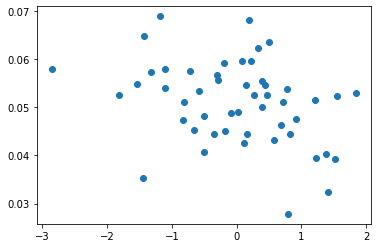

In [38]:
X_train, _, y_train, _ = generate_data(100, 1) # 1D input for plotting
plt.scatter(X_train, y_train);

We will now generate a bigger dataset (both in the number of samples and dimensions), a good deal of which will be used for testing (so that we can illustrate overfitting). We will then create a simple linear regression model and train it. When training we will implement the $l_2$ regularization discussed above to see how it affects the test loss.

In [39]:
INPUT_DIM = 200

X_train, X_test, y_train, y_test = generate_data(samples=100, N=INPUT_DIM, test_size=0.5, scale=0.01)

In [40]:
def train(model, optimizer, loss_fn, num_epochs=1000, lambda_=0.1, verbose=True):
  # needed for plotting
  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    # regularization
    l2 = sum(p.pow(2).sum() for p in model.parameters())/2
    loss = loss_fn(pred, y_train) + lambda_ * l2 # see formula above
    loss.backward()
    optimizer.step()

    # inference during training
    with torch.no_grad():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)

    # needed for plotting
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 200 == 0 and verbose:
      print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  if verbose:
    plt.figure(figsize=(6, 4))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

Try to understand why the line which calculates regularization function's output has two `sum` functions: `l2 = sum(p.pow(2).sum() for p in model.parameters())/2`. We have plotting logic in the function above for demonstration purposes, and we will give different $λ$ values to customize our regularizer $R$ ($λ$=0 implies no regularization).

In [41]:
import torch.nn as nn
import torch.optim as optim

model = nn.Linear(INPUT_DIM, 1)
optimizer = optim.SGD(model.parameters(), lr=0.001)
mse = nn.MSELoss()

Epoch 0, Train Loss: 0.3334, Test Loss: 0.3407
Epoch 200, Train Loss: 0.0219, Test Loss: 0.2706
Epoch 400, Train Loss: 0.0038, Test Loss: 0.2625
Epoch 600, Train Loss: 0.0009, Test Loss: 0.2619
Epoch 800, Train Loss: 0.0002, Test Loss: 0.2623


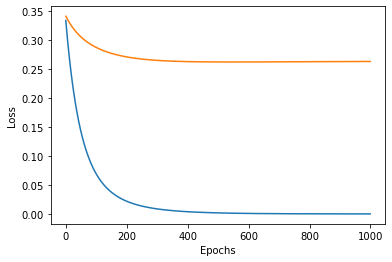

In [42]:
train(model, optimizer, mse, lambda_=0.0) # no regularization

Epoch 0, Train Loss: 0.6721, Test Loss: 0.2603
Epoch 200, Train Loss: 0.0960, Test Loss: 0.0480
Epoch 400, Train Loss: 0.0190, Test Loss: 0.0179
Epoch 600, Train Loss: 0.0087, Test Loss: 0.0133
Epoch 800, Train Loss: 0.0073, Test Loss: 0.0125


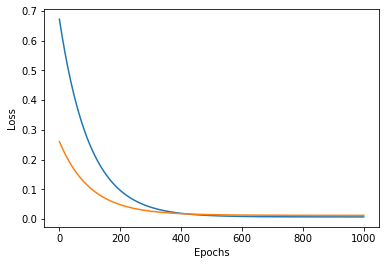

In [43]:
train(model, optimizer, mse, lambda_=5.0) # with regularization

As can be observed, without regularization, model overfits heavily on the train data. Even though the loss of the train data reaches a very small value very quick, the loss of the test split struggles to decline after epoch 200 or so. On the contrary, regularization has a great effect during training, bringing the test loss down very quickly (in our oversimplified example, even faster than the train split).

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    Try out different $\lambda$ to see how different regularization intensities influence the output.
  </p>
</div>

## Dropout

The more complicated the model is, the more chance it has to overfit the train data. In order to improve the generalization ability of our model to unseen data, we may aim for a simpler model.Regularization with weight decay achieved that to some degree but it's not the only solution. [Srivastava et al. (2014)](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) building on top of the earlier idea developed by [Bishop (1995)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-tikhonov-nc-95.pdf) came up with the concept called [dropout](https://en.wikipedia.org/wiki/Dilution_\(neural_networks\)). Dropout literally drops out some neurons during training by setting their activations to zero.



<figure>
  <img src="../../assets/images/regul_optim/dropout.svg" alt="Dropoutn" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Dropout is simply "turning off" neurons ~ <a href='https://d2l.ai/chapter_multilayer-perceptrons/dropout.html'>Dive into Deep Learning</a>, <a href="https://d2l.ai/_images/dropout2.svg">Fig. 5.6.1</a>.
    <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC BY-SA 4.0</a>.
  </figcaption>
</figure>

We will implement the operation in its simplistic form below.

In [44]:
X = torch.arange(1,7)
f"Initial layer activations: {X}"

'Initial layer activations: tensor([1, 2, 3, 4, 5, 6])'

In [45]:
prob = 0.5 # try out different values between 0 and 1
mask = (torch.rand(X.shape) > prob ).float()
f"Random mask with dropout probability {prob}: {mask}"

'Random mask with dropout probability 0.5: tensor([0., 0., 0., 1., 0., 1.])'

In [46]:
X_dropout = X * mask
f"Layer activations after dropout {X_dropout}"

'Layer activations after dropout tensor([0., 0., 0., 4., 0., 6.])'

In [47]:
X_dropout_scaled = X_dropout / (1.0 - prob + 1e-9)
f"Scaled activations after dropout {X_dropout_scaled}"

'Scaled activations after dropout tensor([ 0.,  0.,  0.,  8.,  0., 12.])'

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Explain why scaling activations is required for dropout.
  </p>
</div>

The idea behind dropout is that it injects noise to the network during training. If a model can achieve good accuracy with noise, it implies that the model has learned a more generalizable function. Dropping out certain proportion of neurons in each iteration basically guides the model to train a smaller network. Scaling is done so that the expected sum of activations will roughly remain the same to compensate for missing activations.

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
  Although a useful technique, dropout should be used carefully in order to not hurt the overall performance of the model.
  </p>
</div>

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
  Note that in some framework implementations <code>keep_prob</code> flag can be used during dropout, which keeps all the nodes in case of being set to <code>1.0</code>. In the PyTorch implementation, the same is achieved by doing the opposite and setting the probability to $0$.</p>
</div>

We will now implement an equivalent of [nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) module of PyTorch. Dropout probability is usually set higher for bigger layers and layers closer to the input. Once the training is over, dropout is usually switched off (recall `model.eval()`). However, it can also be used in the test time for estimating the uncertainty of the neural network.

In [48]:
class Dropout(nn.Module):
  def __init__(self, prob):
    super().__init__()
    assert 0 <= prob <= 1
    self.prob = prob
    self.epsilon = 1e-8

  def forward(self, X):
    if self.training: # model.eval() will set training to false
      mask = (torch.rand_like(X) > self.prob).float()
      X = X * mask / (1.0 - self.prob + self.epsilon)
    return X

In [49]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_DIM, 256),
    nn.ReLU(),
    Dropout(0.5), # nn.Dropout(0.5)
    nn.Linear(256, 128),
    nn.ReLU(),
    Dropout(0.3), # nn.Dropout(0.3)
    nn.Linear(128, 10)
)

## Data Augmentation

Data augmentation is a regularization technique that creates new training examples by applying random, label-preserving transformations to existing data. Instead of training on a fixed dataset, we train on slightly different versions of the same samples at each epoch. This increases the effective size and diversity of the training set. Augmentation forces the model to learn features that remain stable under small perturbations. As a result of this noise, memorization becomes harder and generalization improves.

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    In practice, augmentation is applied only to the training data. The test split should remain unchanged so that evaluation reflects the true data distribution. Augmentations must also preserve the label. For example, flipping a handwritten $9$ may turn it into a $6$, which breaks the supervision signal.
  </p>
</div>

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    Data augmentation is especially powerful in computer vision, where transformations such as small rotations, crops, flips, and color changes preserve the semantic meaning of the image.
  </p>
</div>

Consider a small $4 \times 4$ image represented as a tensor. A horizontal flip produces a different pixel arrangement, but it represents the same object. Training on both versions encourages the model to rely less on exact pixel positions.

In [50]:
X = torch.tensor([
  [1, 2, 3, 4],
  [5, 6, 7, 8],
  [9,10,11,12],
  [13,14,15,16]
])

X_flip = torch.flip(X, dims=[1])

X, X_flip

(tensor([[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]),
 tensor([[ 4,  3,  2,  1],
         [ 8,  7,  6,  5],
         [12, 11, 10,  9],
         [16, 15, 14, 13]]))

Regularization methods aim to reduce overfitting and, consequently, improve the generalization ability of models. So far, we have looked at three main regularization techniques: $l_2$ regularization, dropout, and data augmentation. To conclude this section on regularization, it is also worth mentioning a technique called [early stopping](https://en.wikipedia.org/wiki/Early_stopping), which simply stops training when the validation loss stops improving. We will now go a step further and discuss how to optimize our models to efficiently minimize the loss and converge to a good solution.

## Exploding & Vanishing Gradients

When building neural network from scratch in earlier notebooks, we have been initilializing our parameters rather randomly. It turns out, by taking certain measures when initializing weights, we can influence the speed and convergence of our training. But before that, we need to discuss how poor parameter initialization can cause problems formally known as [vanishing (exploding) gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    See the material on <a href='../../mathematics/03_probability'>probability theory</a> in case of having difficulties with the concepts described in this and following sections.
  </p>
</div>

By [chain rule](../../mathematics/01_calculus), we know that the gradients are multiplied within the neural network. Hence, multiplying many gradients that have large values along our network will "explode" the final gradient, resulting in unnessarily big jumps and missing the minimum of the function (and thus not converging). The opposite is also true: if the gradients are too small then multiplying lots of small values will result in a number that is almost zero, causing the _vanishing gradient problem_. With gradients almost zero, values during backpropagation will not get updated and the learning will stop.

In [51]:
W = torch.normal(mean=0, std=1, size=(3, 3)) # Gaussian distribution matrix

num_epochs = 20
for _ in range(num_epochs):
  W = W @ torch.normal(mean=0, std=1, size=(3, 3)) # matrix multiplication of N such matrices
W

tensor([[-213.2879, -109.1465, -217.0422],
        [ -71.5859,  -35.5326,  -73.4408],
        [  33.6598,   15.1526,   35.3727]])

We will now take three activation functions (`sigmoid`, `relu`, `leaky_relu`) and plot their functions together with their graident values.

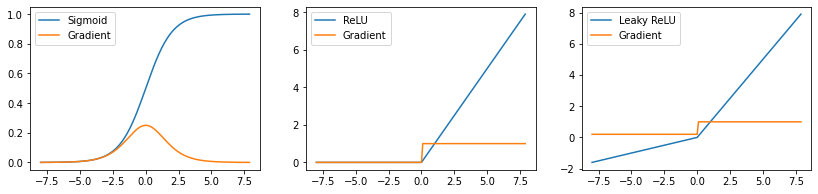

In [52]:
plt.figure(figsize=(14,3))

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

acts = [
  ("Sigmoid", torch.sigmoid),
  ("ReLU", torch.relu),
  ("Leaky ReLU", lambda t: torch.nn.functional.leaky_relu(t, 0.2)),
]

for i, (name, f) in enumerate(acts, 1):
  x.grad = None
  y = f(x)
  y.backward(torch.ones_like(x))

  plt.subplot(1, 3, i)
  plt.plot(x.detach().numpy(), y.detach().numpy(), label=name)
  plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label="Gradient")
  plt.legend()

plt.show()

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
     Try to interpret what the plots mean.
  </p>
</div>

As can be seen, for the sigmoid function, the gradients are almost zero for low and high ends of the function (saddle points) due to its gradient being $σ(x)(1−σ(x))$. Since the publication of the [AlexNet](../../introduction/01_deep_learning) paper, in order to avoid the vanishing gradient problem, ReLU activation is usually preferred over sigmoid. 

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    When the output is mapped to  negative values, the ReLU derivates become zero,  causing so-called <a href='https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks'>dying ReLU problem</a>, which can be solved to some degree with the help of <a href='https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html'>Leaky ReLU</a> (or other ReLU variants) where the gradients do not become exactly zero when the output value. Still, in practice, ReLU is usually robust enough.
  </p>
</div>

## Weight Initialization

Proper [weight initialization](https://en.wikipedia.org/wiki/Weight_initialization) is crucial for stable training of deep neural networks. If the initial weights are chosen poorly, activations may explode or vanish as they propagate through layers. 

To understand this phenomenon, let us analyze a very simple linear layer without activation and bias. We know that the next layer's values will be affected by the following sum: $\text{out}_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j$. We assume that the weights are initialized from a zero-mean normal distribution $w_{ij} \sim \mathcal{N}(0, \sigma^2)$. Recall that the expectation $E$ of a random variable represents the average value you would expect if you repeated the experiment many times.

<div style="overflow-x:auto; max-width:100%;">
$$
\begin{aligned}
\mathbb{E}[\text{out}_i] 
= \sum_{j=1}^{n_{\mathrm{in}}} \mathbb{E}[w_{ij} x_j] 
&= \sum_{j=1}^{n_{\mathrm{in}}} \mathbb{E}[w_{ij}] \, \mathbb{E}[x_j] \\
&= \sum_{j=1}^{n_{\mathrm{in}}} 0 \cdot \mathbb{E}[x_j] 
= 0.
\end{aligned}
$$
</div>

Also recall that variance measures the spread of data around its mean, where squaring is applied so that negative and positive values will not cancel each others out. Considering that weights and inputs are independent:

<div style="overflow-x:auto; max-width:100%;">
$$
\begin{aligned}
\mathrm{Var}[\text{out}_i] 
&= \mathbb{E}[\text{out}_i^2] - (\mathbb{E}[\text{out}_i])^2 \\
&= \sum_{j=1}^{n_{\mathrm{in}}} \mathbb{E}[w_{ij}^2 x_j^2] - 0 = \sum_{j=1}^{n_{\mathrm{in}}} \mathbb{E}[w_{ij}^2] \, \mathbb{E}[x_j^2] \\
&= n_{\mathrm{in}} \sigma^2 \gamma^2
\end{aligned}
$$
</div>

The term $n_{\mathrm{in}} \sigma^2 \gamma^2$ appears because the output is a sum of $n_{\mathrm{in}}$ independent random terms. For a single term $w_{ij} x_j$, we assume the weights have variance $\sigma^2$ and the inputs have variance $\gamma^2$. Under independence and zero-mean assumptions, the variance of the product becomes

$$\mathrm{Var}[w_{ij} x_j] = \mathrm{Var}[w_{ij}] \, \mathrm{Var}[x_j] = \sigma^2 \gamma^2.$$

Since the output is a sum of $n_{\mathrm{in}}$ such independent terms, and the variance of independent variables adds, the total variance becomes $n_{\mathrm{in}} \sigma^2 \gamma^2.$ In other words, each input contributes some spread to the output, and adding more inputs increases the total spread linearly. This is why the variance of the output grows proportionally to the number of input neurons.

In [53]:
n_out = 10
for n_in in [10**i for i in range(5)]:
  X = torch.randn(n_in)
  W = torch.normal(mean=0, std=1, size=(n_in, n_out))
  O = X @ W
  print(f'n_in: {n_in}, var(o): {O.var().item()}')

n_in: 1, var(o): 0.16098813712596893
n_in: 10, var(o): 3.3858141899108887
n_in: 100, var(o): 181.25555419921875
n_in: 1000, var(o): 259.7041931152344
n_in: 10000, var(o): 5145.6123046875


<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    How can we avoid the exploding gradient problem of random initialization?
  </p>
</div>

To mitigate the exploding gradient problem, an obvious trick is to ensure stability of the variance by enforcing $n_\textrm{in} \sigma^2 = 1$. [(Xavier) Glorot and Bengio (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) proposed the ingenious solution of setting the standard deviation to $\sigma = \sqrt{\frac{1}{n_\textrm{in}}}$.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    How would you extend this reasoning to the case of backpropagation?
  </p>
</div>

With the same logic, to keep the gradient variance consistent, we should ensure $n_\textrm{out} \sigma^2 = 1$, where $n_\textrm{out}$ is the number of output neurons. To satisfy both cases, we average the variance scaling, obtaining $(n_\textrm{in} + n_\textrm{out}) \sigma^2 = 2$, or equivalently $\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}$.

**Xavier initialization** is mainly used for sigmoid and tanh activations. The paper [He et al. (2015)](https://arxiv.org/pdf/1502.01852) addresses rectified non-linearities. Since the ReLU function does not suffer from the vanishing gradient problem in the same way as sigmoid or tanh, backpropagation does not shrink the variance as severely. Hence, (Kaiming) **He initialization** takes the form $\sigma = \sqrt{\frac{2}{n_\textrm{in}}}$.


In [95]:
n_out = 10
for n_in in [10**i for i in range(5)]:
  X = torch.randn(n_in)
  W = torch.normal(mean=0, std=torch.sqrt(torch.tensor(2.0 / n_in)), size=(n_in, n_out))
  O = X @ W
  print(f'n_in: {n_in}, var(o): {O.var().item():.4f}')

n_in: 1, var(o): 0.8965
n_in: 10, var(o): 1.9641
n_in: 100, var(o): 1.3890
n_in: 1000, var(o): 1.4248
n_in: 10000, var(o): 1.3977


As $n_\textrm{in}$ grows, the variance of the output stays roughly constant, showing that our initialization ($\sigma=\sqrt{2/n_\textrm{in}}$) prevents activations from exploding as width increases.

## Local Minima and Saddle Points

When minimizing a loss function with gradient descent, we often deal with many local and global minima. A local minimum is a point where the loss is smaller than in its immediate neighborhood, but it is not necessarily the smallest value over the entire function. When optimization reaches such a region, progress may slow because gradients become small near the bottom of the valley. In practice, noise or a slightly larger learning rate can sometimes help the parameters escape shallow local minima and continue searching for better solutions.

It is also possible to reach a point where the gradient becomes zero (or very close to zero), yet the point is not a local or global minimum. Such points are called saddle points. A classic example is the two-dimensional function $f(x,y)=x^2-y^2$. The surface resembles a horse saddle with a saddle point at $(0,0)$: the function curves upward in one direction and downward in another. Because neural network loss functions live in very high-dimensional spaces, saddle-type critical points and flat directions tend to appear more often than true local minima.

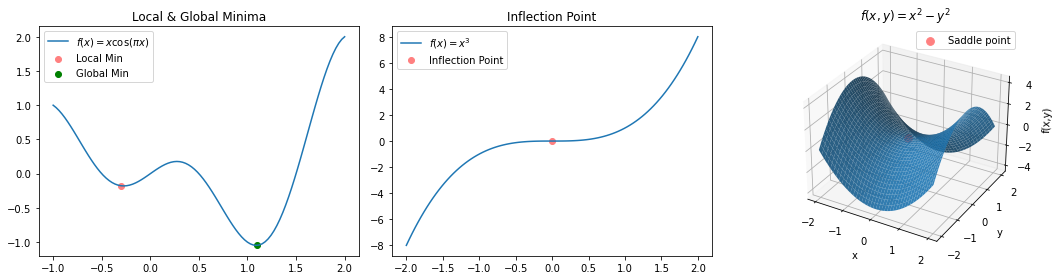

In [3]:
import numpy as np

f1 = lambda x: x * np.cos(np.pi * x)
f2 = lambda x: x**3

x1 = np.linspace(-1, 2, 100)
x2 = np.linspace(-2, 2, 100)

fs = lambda X, Y: X**2 - Y**2

xs = np.linspace(-2, 2, 160)
ys = np.linspace(-2, 2, 160)
X, Y = np.meshgrid(xs, ys)
Z = fs(X, Y)

fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x1, f1(x1), label=r'$f(x)=x\cos(\pi x)$')
ax1.scatter(-0.3, f1(-0.3), color=[1.0, 0.5, 0.5], label="Local Min")
ax1.scatter(1.1, f1(1.1), color='g', label="Global Min")
ax1.set_title("Local & Global Minima")
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(x2, f2(x2), label=r'$f(x)=x^3$')
ax2.scatter(0, 0, color=[1.0, 0.5, 0.5], label="Inflection Point")
ax2.set_title("Inflection Point")
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.plot_surface(X, Y, Z, linewidth=0, antialiased=True, alpha=0.9)
ax3.scatter(0, 0, 0, color=[1.0, 0.5, 0.5], s=60, label="Saddle point")
ax3.set_title(r"$f(x,y)=x^2-y^2$")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("f(x,y)")
ax3.legend()

plt.tight_layout()
plt.show()

## Learning Rate

We have seen from previous experiments how learning rate can affect the training process. When the learning rate is low, parameters take smaller steps towards the minimum, and training becomes slow. When the learning rate is high, it can overshoot the local minima, oscillate around them, or may even never converge.

In [11]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps):
  path = [initial_point]
  x = initial_point
  for _ in range(num_steps):
    grad = grad_f(x)
    x -= learning_rate * grad
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rates=[0.1, 0.3, 0.9, 1.0], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(learning_rates), figsize=figsize)
  for i, lr in enumerate(learning_rates):
    path = gradient_descent(f, grad_f, lr, point, steps)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'LR = {lr}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'LR = {lr}')

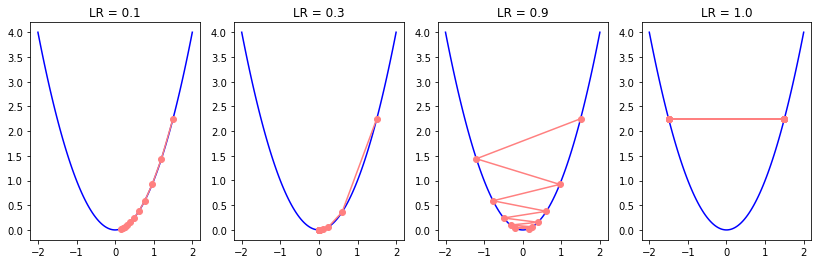

In [12]:
f = lambda x: x**2
grad_f = lambda x: 2*x

plot_descent(f, grad_f, 1.5, 10, -2, 2)



The role of the learning rate changes during training. At the beginning of optimization the parameters are usually far from good solutions and gradients tend to be larger. Larger learning rates help the model move quickly across the loss function and reach useful regions faster. Later in training, when the parameters approach a minimum, gradients become smaller and noisier. If the learning rate remains large, the optimization can oscillate around the minimum. Because of this issue, it is common to use a [learning rate scheduler](https://d2l.ai/chapter_optimization/lr-scheduler.html). A scheduler adjusts the learning rate during training so that optimization can move quickly at first and become more stable later.

A simple strategy is **step decay**, where the learning rate is multiplied by a constant factor (for example $0.1$) every $N$ epochs. Another technique is **learning rate warmup**, where training starts with a small learning rate that gradually increases during the first iterations. This avoids unstable updates when the network parameters are still randomly initialized. After the warmup phase the learning rate reaches its main value and then gradually decreases according to the chosen schedule.


<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    In practice, learning rate decay can also slightly reduce overfitting. As the learning rate becomes smaller later in training, parameter updates stabilize and the model is less likely to keep adapting aggressively to the training data, which can improve generalization.
  </p>
</div>

In the example below the learning rate first increases slightly (warmup) and then gradually decreases (cosine decay). This allows the optimization to move quickly at the beginning and take smaller, more precise steps later.

In [17]:
import numpy as np

def lr_schedule(step, total_steps):
  warmup_steps = int(0.2 * total_steps)

  if step < warmup_steps:
    return step / warmup_steps

  progress = (step - warmup_steps) / (total_steps - warmup_steps)
  return 0.5 * (1 + np.cos(np.pi * progress))

total_steps = 10
base_lr = 0.1

for step in range(total_steps):
  lr = base_lr * lr_schedule(step, total_steps)
  print(f"step {step:02d}: lr = {lr:.4f}")

step 00: lr = 0.0000
step 01: lr = 0.0500
step 02: lr = 0.1000
step 03: lr = 0.0962
step 04: lr = 0.0854
step 05: lr = 0.0691
step 06: lr = 0.0500
step 07: lr = 0.0309
step 08: lr = 0.0146
step 09: lr = 0.0038


In the examples below, we can see how different values of learning rates may postiviely or negatively influence the outcome depending on whether we are close to the local or global minima.

In [ ]:
c = np.array(0.15 * np.pi)
f = lambda x: x * np.cos(c * x)
grad_f = lambda x: np.cos(c * x) - c * x * np.sin(c * x)

In [ ]:
plot_descent(f, grad_f, point=10, steps=10, start=-13, end=13, learning_rates=[0.3, 1.3, 2.0])

In [ ]:
plot_descent(f, grad_f, point=-7, steps=5, start=-13, end=13, learning_rates=[0.5, 2.7, 3.5])

## Stochastic Gradient Descent

A slightly modified version of the gradient descent, the minibatch [Stochastic Gradient Descent (SGD)](https://www.youtube.com/watch?v=vMh0zPT0tLI) has the ability to avoid local minima, as the variation of gradients in the _minibatches_ bring noise and affect the parameter update. In SGD, instead of averaging the gradients of all data (batch) samples, we randomly choose only a single sample to approximate the average gradient. In case of [minibatch SGD](https://d2l.ai/chapter_optimization/minibatch-sgd.html), we choose a small data subset (minibatch) instead of a single data point (SGD) or all data points (BGD) and average the minibatch gradients to approximate the average of full batch gradients.

We saw how different values of the learning rate can positively or negatively influence optimization. At the same time, SGD itself introduces randomness because each minibatch produces a slightly different gradient estimate. This variability slightly changes the update direction at every step and can help the optimization continue moving instead of getting stuck in local minima, even when the learning rate remains fixed.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
  In modern neural networks the main difficulty is often not true local minima but saddle points. Because the gradient magnitude in saddle points becomes very small, deterministic batch gradient descent can slow down training significantly. The small variations introduced by minibatch SGD change the gradient estimate from step to step, which helps the parameters continue moving.
  </p>
</div>

## Momentum

We have observed that gradient descent can be sensitive to the choice of learning rate and may oscillate when gradients change direction. One way to stabilize the updates is to encourage the optimization process to keep moving in consistent directions. It can be achieved with [momentum](https://d2l.ai/chapter_optimization/momentum.html), which adds a velocity term with acceleration to parameter updates. 

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
  Momentum behaves similarly to how a ball would roll down a hill. It builds speed as we move in the direction of the gradient, helping the training converge faster and more smoothly. This explanation, however, is oversimplistic. If you have a good mathematical background, you can find a nice explanation in this <a href='https://distill.pub/2017/momentum/'>distill article on momentum</a>.
  </p>
</div>

Recall that gradient descent for parameter $\theta$ had the following formula at step $t$ where $\nabla_{\theta} L(\theta_t)$ is gradient of loss and $\eta $ is learning rate:

$$ \theta_{t+1} = \theta_t - \eta \nabla_{\theta} L(\theta_t)$$

Momentum introduces a velocity term $v$ that accumulates gradients from previous steps. It is scaled by a momentum hyperparameter $\beta$, where $\beta \in (0,1)$. Unlike the learning rate hyperparameter, $\beta$ is rarely tuned and is commonly set to $0.9$. Instead of following only the gradient of the current step, the update becomes a weighted average of recent gradients. As a result, parameters continue moving in consistent directions and oscillations are reduced.

$$ v_t = \beta v_{t-1} +\nabla_{\theta} L(\theta_t) \\
\theta_{t+1} = \theta_t - \eta v_t $$

You will usually see a slightly modified version of the velocity, which scales the current gradient by $(1-\beta)$:

$$ v_t = \beta v_{t-1} + (1 - \beta)\nabla_{\theta} L(\theta_t)$$

You can imagine $\beta$ value to be an averaging factor. As the gradients accumulate, we may want to give less weight to the current gradient, which $1-\beta$ achieves. When $\beta=0$, momentum disappears and the update reduces to standard gradient descent. When $\beta$ becomes very close to $1$, the optimizer keeps a very long memory of past gradients, which makes updates smoother but slower to respond to new information. For this reason, typical values are $0.9$, $0.99$, or sometimes $0.999$, but never exactly $1$.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
  The value $\beta = 0.9$ is widely used in practice because it keeps a useful memory of recent gradients without making the optimizer too slow to react. With this value, the moving average roughly reflects information from the last $\frac{1}{1-\beta}$ updates. Larger values (e.g. $0.99$) make the updates very smooth but slower to adapt, while smaller values reduce the benefit of momentum.
  </p>
</div>

In [21]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, momentum=0.9):
  assert momentum <= 1 and momentum >= 0
  path = [initial_point]
  x = initial_point

  beta = momentum
  v = 0.0
  for _ in range(num_steps):
    grad = grad_f(x)
    v = beta * v + (1 - beta) * grad
    x -= learning_rate * v
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, momentums=[0.1, 0.5, 0.9], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(momentums), figsize=figsize)
  for i, momentum in enumerate(momentums):
    path = gradient_descent(f, grad_f, learning_rate, point, steps, momentum)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'M = {momentum}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'M = {momentum}')

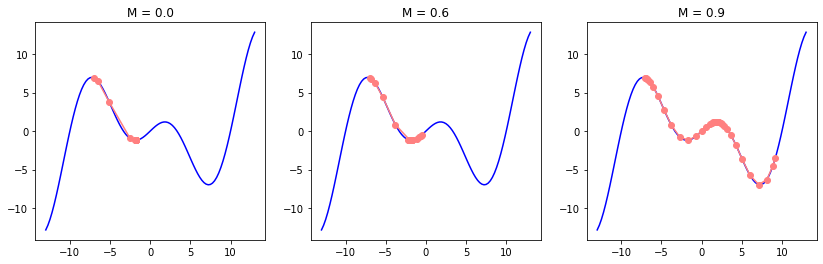

In [22]:
plot_descent(f, grad_f, point=-7, steps=35, start=-13, end=13, learning_rate=1.1, momentums=[0.0, 0.6, 0.9])

## RMSProp

We can further optimize learning with the [RMSProp](https://optimization.cbe.cornell.edu/index.php?title=RMSProp) algorithm. RMSProp adjusts the parameter step size (learning rate) based on the historical magnitude of the parameter gradients. For that, the learning rate is divided by a running average of squared gradients. This helps to avoid large updates in regions where gradients are large, while allowing for bigger steps in flatter regions of the function. Squaring and then desquaring (finding the square root) is a common technique for dealing with negative values (similar to finding MSE or standard deviation). 

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    RMSProp has a common abbreviation with MSE: the algorithm's full title is <em>Root Mean Squared Propagation</em>. 
  </p>
</div>

The state $s$ in the formula below (which should seem familiar) holds the running average of squared gradients, which is then used to scale the learning rate for each parameter.

$$s_t = \gamma s_{t-1} + (1 - \gamma) \nabla_{\theta} L(\theta_t)^2$$

The updated parameter $\theta$ is then divided by the square root of this state vector. To avoid division by zero and achieve numerical stability $ϵ$ (a very small number close to zero) is added. The term $\sqrt{s_t}$ represents the root of the running average of squared gradients, normalizing the gradient for each parameter.

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{s_t} + \epsilon} \nabla_{\theta} L(\theta_t)$$

RMSprop often performs well when dealing with noisy or sparse gradients, and the parameter $\gamma$ typically ranges between $0.9$ and $0.99$. 

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    Note that RMSProp updates each parameter individually. Its formula may appear complicated, but the idea is simple: each parameter update is scaled using the recent magnitudes of its gradients. If a parameter has consistently large gradients, its update becomes smaller, if the gradients are small, the update remains larger.
  </p>
</div>

In the example below, we optimize a single parameter so that the behavior of RMSProp can be visualized easily. Many deep learning ideas are first illustrated in low dimensions for clarity, but the same principle extends to models with many parameters. In practice, RMSProp adjusts the update of each parameter using its recent gradients, so different parameters move with different step sizes.

In [25]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, gamma=0.9):
  assert gamma <= 1 and gamma >= 0
  path = [initial_point]
  x = initial_point

  s = 0.0
  epsilon=1e-8
  for _ in range(num_steps):
    grad = grad_f(x)
    s = gamma * s + (1 - gamma) * grad**2
    x -= learning_rate * grad / (np.sqrt(s) + epsilon)
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, gammas=[0.9, 0.99, 0.999], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(gammas), figsize=figsize)
  for i, gamma in enumerate(gammas):
    path = gradient_descent(f, grad_f, learning_rate, point, steps, gamma)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'G = {gamma}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'G = {gamma}')

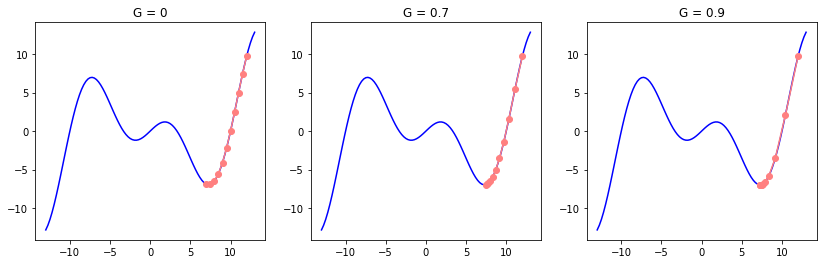

In [26]:
plot_descent(f, grad_f, point=12, steps=10, start=-13, end=13, learning_rate=0.5, gammas=[0, 0.7, 0.9])

## Adam

You might have noted certain similarities in momentum and RSMProp formulas. But can't we simply make the best out of both worlds and integrate them into a single gradient descent function? It turns out we can. Adam ([Kingma and Ba, 2014](https://arxiv.org/pdf/1412.6980)) stands for _Adaptive Moment Estimation_ and does exactly that:

$$
\begin{aligned}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) \nabla_{\theta} L(\theta_t) \\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) \nabla_{\theta} L(\theta_t)^2.
\end{aligned}
$$

We should note a couple of more things. The common values for weights are $\beta_1=0.9$ and $\beta_2=0.999$ (why not $\beta_2=1.0$ we discussed above), as variance estimate $s_t$ is much slower than the momentum. As we initilize it together with velocity to zero ($v=s=0$) we initially get bias towards smaller values. It can be fixed with normalization:   

$$\hat{v_t} = \frac{v_t}{1 - \beta_1^t}, \quad \hat{s_t} = \frac{s_t}{1 - \beta_2^t}$$

Here $v_t$ and $s_t$ are called moments. Let's see how normalized moments get affected after the first two iterations:

<div style="overflow-x:auto; max-width:100%;">
$$
\beta_1 = 0.9^1 = 0.9 \quad \Rightarrow \quad \frac{1}{1 - \beta_1^1} = \frac{1}{0.1} = 10 \\
\beta_1^2 = 0.9^2 = 0.81 \quad \Rightarrow \quad \frac{1}{1 - \beta_1^2} = \frac{1}{0.19} \approx 5.26 \\
\beta_2^1 = 0.999^1 = 0.999 \quad \Rightarrow \quad \frac{1}{1 - \beta_2^1} = \frac{1}{0.001} = 1000 \\
\beta_2^2 = 0.999^2 = 0.998001 \quad \Rightarrow \quad \frac{1}{1 - \beta_2^2} = \frac{1}{0.001999} \approx 500
$$
</div>

Finally, we can integrate the accumulated values into our gradient descent formula to get the final step size:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{s_t}} + \epsilon} \hat{v_t}$$

In [65]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, b1=0.9, b2=0.999, normalize=False):
  assert b1 <= 1 and b1 >= 0
  assert b2 <= 1 and b2 >= 0
  path = [initial_point]
  x = initial_point

  v = 0.0
  s = 0.0
  epsilon=1e-8
  for t in range(1, num_steps + 1):
    grad = grad_f(x)
    v = b1 * v + (1 - b1) * grad
    s = b2 * s + (1 - b2) * grad**2
    # as our function and plot are simple, we will keep
    # unnormalized option as well for demonstration purposes
    v_hat = v / (1 - b1**t) if normalize else v
    s_hat = s / (1 - b2**t) if normalize else s
    x -= learning_rate * v_hat / (np.sqrt(s_hat) + epsilon)
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, b1_vals=[0.9, 0.99, 0.999], b2_vals=[0.1, 0.99, 0.999], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(len(b1_vals), len(b2_vals), figsize=figsize)
  for i, b1 in enumerate(b1_vals):
    for j, b2 in enumerate(b2_vals):
      path = gradient_descent(f, grad_f, learning_rate, point, steps, b1, b2)
      axs[i, j].plot(x_vals, y_vals, color='b')
      axs[i, j].plot(path, f(path), marker='o', label=f'B1 = {b1}, B2 = {b2}', color=[1.0, 0.5, 0.5])
      axs[i, j].set_title(f'B1 = {b1}, B2 = {b2}')

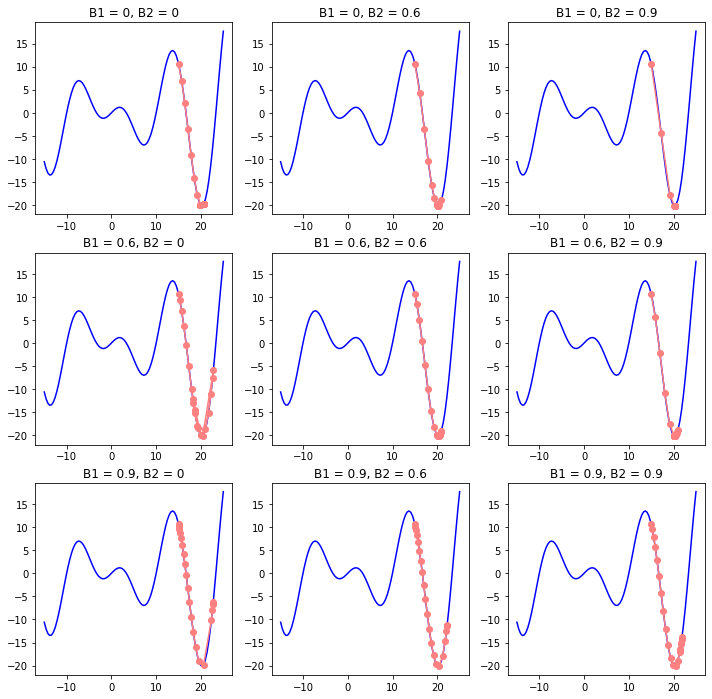

In [66]:
plot_descent(f, grad_f, point=15, steps=20, start=-15, end=25, learning_rate=0.7, b1_vals=[0, 0.6, 0.9], b2_vals=[0, 0.6, 0.9], figsize=(12, 12))

## Training Efficient Model

Instead of simple grayscale MNIST dataset, we will choose [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) this time to train our model on. It consists of 50,000 training and 10,000 test images of size $32 \times 32$ divided into 10 classes. An alternative version of the dataset called _CIFAR-100_ has 100 classes. Unlike MNIST, images have three channels (RGB) which makes computation more expensive and the task of the model more difficult.

We have provided overview of augmentation above. In practice, augmentation is implemented directly in the dataset pipeline so that every time a sample is loaded, a slightly different version of the image is produced. Several simple transformations are commonly used. For example, _random crop with padding_ introduces small translations and prevents the model from relying on exact pixel locations, whereas, _horizontal flip_ makes the model invariant to left–right orientation. On the other hand, _normalization_ stabilizes optimization by ensuring that pixel values have consistent scale across channels. 

During training these transformations are stochastic, meaning that each epoch sees slightly different inputs. In contrast, the test pipeline is deterministic and only converts the image to a tensor and normalizes it.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    In more advanced pipelines, stronger augmentation strategies can be applied. Two widely used examples are particularly useful for small datasets like CIFAR because they significantly reduce overfitting: <a href='https://arxiv.org/pdf/1710.09412'>MixUp (Zhang et al, 2017)</a> linearly combines two images and their labels helping the model learn smoother decision boundaries.  <a href='https://arxiv.org/abs/1905.04899'>CutMix (Sangdoo et al, 2019)</a> inserts a rectangular patch from one image into another, and the labels are mixed proportionally to the patch area which encourages the model to rely on distributed visual evidence rather than a single region. 
  </p>
</div>

Below we define the PyTorch dataset transformations and create the training and test loaders.

In [34]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_PATH = '../../_drafts/data' # modify accordingly (e.g. to './data')

# Per-channel (R,G,B) mean and standard deviation of the CIFAR-10 training set.These values were computed once from the dataset and are commonly reused.
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor(),
  transforms.Normalize(cifar_mean, cifar_std),
])

test_tfms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(cifar_mean, cifar_std),
])

train_data = datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=train_tfms)
test_data  = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True,  pin_memory=True, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Some portion of the code should be familiar and self-explanatory. We need to briefly discuss others. `TrivialAugmentWide()` applies one randomly selected augmentation with a random magnitude. The operation is sampled from a pool of common image transformations such as rotation, color adjustment, translation, or contrast changes. Because the operation and its strength are chosen automatically, this method provides strong augmentation while keeping the code simple.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    Note that this augmentation is applied in addition to the earlier random crop and horizontal flip. Although some transformations in the pool may partially overlap with the earlier ones, keeping the basic augmentations explicitly in the pipeline ensures that these important variations appear consistently during training. The additional stochastic augmentation simply increases diversity beyond these core transformations.
  </p>
</div>

Pixel values originally lie in the range $[0, 255]$. `ToTensor()` converts them into floating point numbers scaled to $[0, 1]$. The images are then normalized using the dataset statistics: mean and standard deviation. Normalization centers the input distribution around zero and scales it so that each channel has comparable variance. This stabilizes optimization and typically improves convergence.

The `DataLoader` objects create minibatches of images and labels that are fed to the model during training. Shuffling is enabled for the training data because modern neural networks are optimized with minibatch SGD. If the samples were always processed in the same order, consecutive batches could contain very similar examples (for example images from the same class appearing together in the dataset). This can bias the gradient estimates and slow down learning. Shuffling ensures that each minibatch is a more random mixture of samples, which makes the gradient a better approximation of the true dataset gradient and usually improves convergence.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    For the test loader, why shuffling is unnecessary?
  </p>
</div>

The loader also includes a few parameters that affect performance rather than the learning algorithm itself: `num_workers` controls how many CPU processes prepare data in parallel. Loading images, applying transformations, and forming batches takes time. If this work is done by a single process, the GPU may sit idle waiting for the next batch. Increasing the number of workers allows multiple batches to be prepared simultaneously, which helps keep the GPU busy.

On the other hand, `pin_memory=True` is useful when training on a GPU. Normally, data is first stored in regular CPU memory and then copied to GPU memory. When memory is "pinned" (page-locked), these transfers can happen faster and more efficiently. In practice this often reduces the time spent moving data to the GPU. Together, parallel workers and pinned memory help the training loop spend more time computing gradients and less time waiting for data.

In [35]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

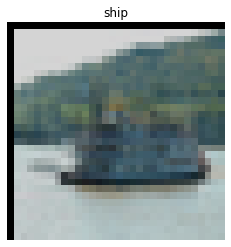

In [54]:
X_batch, y_batch = next(iter(train_loader))
x = X_batch[0]  # (C,H,W), normalized
y = y_batch[0].item()

mean = torch.tensor(cifar_mean).view(3, 1, 1)
std  = torch.tensor(cifar_std).view(3, 1, 1)

x_vis = (x * std + mean).clamp(0, 1)  # back to [0,1]

plt.imshow(x_vis.permute(1, 2, 0))
plt.title(idx_to_class[y])
plt.axis("off");

In [55]:
# Note that augmentation is applied during training time on the fly
f"Train/test split size: {len(train_data)}/{len(test_data)}"

'Train/test split size: 50000/10000'

In [56]:
f"Train/test batch count: {len(train_loader)}/{len(test_loader)}"

'Train/test batch count: 782/157'

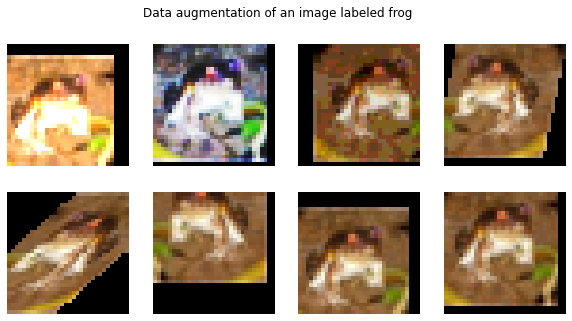

In [60]:
import torch
from PIL import Image

img = Image.fromarray(train_data.data[0])
label = train_data.targets[0]

fig, axes = plt.subplots(2,4, figsize=(10,5))

for ax in axes.flat:
    aug = train_data.transform(img)
    aug = aug * std + mean     # undo normalization
    aug = aug.clamp(0,1)
    ax.imshow(aug.permute(1,2,0))
    ax.axis("off")

plt.suptitle(f"Data augmentation of an image labeled {idx_to_class[label]}")
plt.show()

We will now train our custom [CNN model](../03_cnn_torch) by applying regularization and optimization methods we have discussed throughout this notebook. Pay attention to the architecture, try to understand the input dimensions. In order to initialize our weights non-randomly, we will **not** use `nn.Lazy` modules.

In [63]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout
    nn.Linear(256, 10)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=256, out_features=10, bias=True)
)

In [64]:
# Moment weigths are by default 0.9 and 0.999 for Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

NameError: name 'optim' is not defined

In [ ]:
# Kaiming He Initialization
for layer in model:
  if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
    if layer.bias is not None:
      nn.init.zeros_(layer.bias)

In [ ]:
model.train()

num_epochs = 100
for epoch in range(num_epochs):
  loss = 0.0
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    preds = model(X_train)
    batch_loss = loss_fn(preds, y_train)
    batch_loss.backward()
    loss += batch_loss.item()
    optimizer.step()

  if (epoch + 1) % 10 == 0 or epoch == 0:
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss/len(train_loader):.4f}')

Epoch: 1/50, Loss: 1.6063
Epoch: 2/50, Loss: 1.3142
Epoch: 3/50, Loss: 1.2205
Epoch: 4/50, Loss: 1.1668
Epoch: 5/50, Loss: 1.1335
Epoch: 6/50, Loss: 1.0996
Epoch: 7/50, Loss: 1.0810
Epoch: 8/50, Loss: 1.0594
Epoch: 9/50, Loss: 1.0465
Epoch: 10/50, Loss: 1.0295
Epoch: 11/50, Loss: 1.0175
Epoch: 12/50, Loss: 1.0196
Epoch: 13/50, Loss: 0.9891
Epoch: 14/50, Loss: 0.9799
Epoch: 15/50, Loss: 0.9781
Epoch: 16/50, Loss: 0.9729
Epoch: 17/50, Loss: 0.9789
Epoch: 18/50, Loss: 0.9651
Epoch: 19/50, Loss: 0.9611
Epoch: 20/50, Loss: 0.9605
Epoch: 21/50, Loss: 0.9545
Epoch: 22/50, Loss: 0.9485
Epoch: 23/50, Loss: 0.9362
Epoch: 24/50, Loss: 0.9436
Epoch: 25/50, Loss: 0.9309
Epoch: 26/50, Loss: 0.9296
Epoch: 27/50, Loss: 0.9240
Epoch: 28/50, Loss: 0.9205
Epoch: 29/50, Loss: 0.9164
Epoch: 30/50, Loss: 0.9104
Epoch: 31/50, Loss: 0.9124
Epoch: 32/50, Loss: 0.9160
Epoch: 33/50, Loss: 0.9211
Epoch: 34/50, Loss: 0.9067
Epoch: 35/50, Loss: 0.9168
Epoch: 36/50, Loss: 0.9151
Epoch: 37/50, Loss: 0.9065
Epoch: 38/

In [ ]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)
    preds = model(X_test)
    _, predicted = torch.max(preds, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 68.98%


## Hyperparameter Tuning

So far we have defined a model architecture and trained it using a specific set of choices: learning rate, optimizer, batch size, dropout rate, and so on. We should already know that these choices are called _hyperparameters_. Unlike the model weights, hyperparameters are not learned during training — they are selected by the practitioner. Typical hyperparameters in deep learning include:

- learning rate  
- optimizer (SGD, Adam, RMSProp)  
- batch size  
- number of epochs  
- dropout probability  
- weight decay  
- network width or depth
- etc.

Different values can lead to very different training behavior. Some settings make optimization unstable, while others allow the model to converge quickly and generalize well. Because we usually do not know the best configuration in advance, we experiment with multiple candidates. A practical strategy is to perform a _parameter sweep_. Instead of trying arbitrary values, we define a small set of reasonable candidates and train the model with each of them to observe how sensitive the optimization is to parameters.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    This approach is sometimes called <strong>grid search</strong> when we try all combinations of several hyperparameters. In practice we often start with a simple sweep over one parameter (usually the learning rate), then refine the search around the most promising region.
  </p>
</div>

A simple workflow used in many experiments is:

1. Start with common default values.
2. Sweep the learning rate.
3. Adjust regularization (dropout or weight decay).
4. Increase model capacity if the model underfits.
5. Compare validation or test accuracy.

This iterative process gradually reveals which configuration works best for the dataset. Below we illustrate a small learning-rate sweep for our CIFAR-10 model.

In [ ]:
learning_rates = [1e-4, 5e-4, 1e-3]

results = {}

for lr in learning_rates:
    model = nn.Sequential(
        nn.Conv2d(3,32,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64*8*8,128),
        nn.ReLU(),
        nn.Linear(128,10)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.train()

    for epoch in range(5):  # short training for comparison
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()

    # evaluate
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds,1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    acc = 100 * correct / total
    results[lr] = acc
    print(f"lr={lr} -> accuracy={acc:.2f}%")

print(results)

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Perform a small hyperparameter sweep for the CIFAR-10 model. Try at least three different learning rates, record the final test accuracy for each run, and identify which value gives the best result. As an additional experiment, keep the best learning rate and vary one more parameter such as dropout or weight decay. Observe how the training and test accuracy change.
  </p>
</div>

We built and trained a model for the more challenging CIFAR-10 dataset using PyTorch. Along the way we constructed a complete deep learning pipeline: loading data with `DataLoader`, applying data augmentation, normalizing inputs, defining a CNN architecture, and training it efficiently on batches of data. We also discussed how optimization and regularization influence model performance. Optimization methods such as SGD or Adam determine how the model parameters are updated during training, while techniques such as data augmentation, dropout, and weight decay help control model complexity and improve generalization. We also explored how hyperparameter tuning can further improve results by systematically experimenting with different settings. 